### GLAZER FITTING: Explicit refinement of Glazer modes in a PDF of CaTiO3

In [24]:
# Import packages that we will need.
import os
import yaml
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(os.path.join("utils",
                            "billinge.mplstyle"))

from diffpy.srfit.fitbase import FitContribution, FitRecipe, FitResults, Profile, FitHook
from diffpy.srfit.fitbase.fitresults import initializeRecipe
from diffpy.srfit.structure import constrainAsSpaceGroup
from diffpy.srfit.pdf import PDFParser, PDFGenerator
from diffpy.structure import Structure
from scipy.optimize import least_squares

import numpy as np
from sympy import *
np.seterr(invalid='ignore')

%matplotlib inline

In [2]:
def define_initial_glazer_amplitudes(GLAZERSYSTEM): 
    """
    Takes in the Glazer system ID for the user's chosen Glazer 
    system and returns dict of initial refinement values based 
	on global parameters ALPHA_I, BETA_I and GAMMA_I set by the 
	user.

    Parameters
    ----------
    GLAZERSYSTEM : integer, specifying the Glazer system.

    Returns
    ----------
    tilt_values:   dict, tilt amplitudes alpha, beta and gamma and their values
    """
    a = 0
    b = 0
    c = 0
    
    # Checking for number of active tilt variables depending on the Glazer system:
    if GLAZERSYSTEM in [22, 21, 20, 16, 14, 11, 7, 3]:
        print('This Glazer system has one tilt degree of freedom. \nPlease make sure you have set ALPHA_I')
        a = ALPHA_I
    if GLAZERSYSTEM in [19, 18, 17, 15, 13, 10, 9, 6, 5, 2]:
        print('This Glazer system has two tilt degrees of freedom. \nPlease make sure you have set ALPHA_I and BETA_I.')
        a = ALPHA_I
        b = BETA_I
    if GLAZERSYSTEM in [12, 4, 1]:
        print('This Glazer system has three tilt degrees of freedom. \nPlease make sure you have set ALPHA_I, BETA_I, GAMMA_I.')
        a = ALPHA_I
        b = BETA_I
        c = GAMMA_I

    TILTS = {23: {'alpha': 0, 'beta': 0, 'gamma': 0}, 22: {'alpha': 0, 'beta': 0, 'gamma': -a}, 
               21: {'alpha': 0, 'beta': 0, 'gamma': a}, 20: {'alpha': 0, 'beta': -a, 'gamma': -a}, 
               19: {'alpha': 0, 'beta': -a, 'gamma': -b}, 18: {'alpha': 0, 'beta': a, 'gamma': -b}, 
               17: {'alpha': 0, 'beta': a, 'gamma': -b}, 16: {'alpha': 0, 'beta': a, 'gamma': a}, 
               15: {'alpha': 0, 'beta': a, 'gamma': b}, 14: {'alpha': -a, 'beta': -a, 'gamma': -a}, 
               13: {'alpha': -a, 'beta': -a, 'gamma': -b}, 12: {'alpha': -a, 'beta': -b, 'gamma': -c},
               11: {'alpha': a, 'beta': -a, 'gamma': -a}, 10: {'alpha': a, 'beta': -b, 'gamma': -b}, 
               9: {'alpha': a, 'beta': -a, 'gamma': -b}, 8: {'alpha': a, 'beta': -b, 'gamma': -c}, 
               7: {'alpha': a, 'beta': a, 'gamma': -a}, 6: {'alpha': a, 'beta': b, 'gamma': -b},
               5: {'alpha': a, 'beta': a, 'gamma': -b}, 4: {'alpha': a, 'beta': b, 'gamma': -c}, 
               3: {'alpha': a, 'beta': a, 'gamma': a}, 2: {'alpha': a, 'beta': b, 'gamma': b}, 
               1: {'alpha': a, 'beta': b, 'gamma': c}}
    
    try:
        tilt_values = TILTS[GLAZERSYSTEM]
        print('Refinement will start with values {}. \nPositive values signify in-phase tilt, negative values signify out-of-phase tilt.\n'.format(list(tilt_values.values())))
    except:
        print('Found no start values for the the Glazer tilt amplitudes (ALPHA_I, BETA_I and/or GAMMA_I)')
    return tilt_values


In [29]:
def A_constraints(GLAZERSYSTEM):
	"""
    Takes in the Glazer system ID for the user's chosen Glazer 
    system and returns list of initial refinement values based 
	on global parameters AYDISP_I and AZDISP_I set by the user,
	a list of variables to refine and a dict of constraint 
	equations for the A sites.

    Parameters
    ----------
    GLAZERSYSTEM : integer, specifying the Glazer system.

    Returns
    ----------
    Acons:         dict containing a 8x3 matrix, gives the constraint equations for the atomic positions
	Avars:         list of strings, variables used in the constraints equations
	AdispI:        list of floats, initial values for A cation displacements
    """
	
	print('Setting up constraints and variables for the A cations in Glazer system {}.'.format(GLAZERSYSTEM))
	
	if GLAZERSYSTEM == 10:
		# Constraints for the eight A sites.
		Acons = [[None, '0.25+Aydisp', '0.25+Azdisp'], 
 				[None, '0.25+Azdisp', '0.75+Aydisp'], 
 				[None, '0.75+Azdisp', '0.25+Aydisp'], 
 				[None, '0.75+Aydisp', '0.75+Azdisp'], 
 				[None, '0.25-Aydisp', '0.25-Azdisp'], 
 				[None, '0.25-Azdisp', '0.75-Aydisp'], 
 				[None, '0.75-Azdisp', '0.25-Aydisp'], 
 				[None, '0.75-Aydisp', '0.75-Azdisp']]
		# Variables for the A sites
		Avars = ['Aydisp', 'Azdisp']
		print('Constraints have been created for {}. Please make sure you have specified AYDISP_I and AZDISP_I.'.format(Avars))
		try:
			AdispI = [AYDISP_I, AZDISP_I]
			print('Refinement will start with values {}.\n'.format(AdispI))
		except:
			print('Found no start values for AYDISP_I and AZDISP_I')
	else:
		print('You have chosen Glazer system {}. A cation constraints for this system are yet undefined.\n'.format(GLAZERSYSTEM))
	
	return Acons, Avars, AdispI

In [4]:
"""
Here we define the rotation/tilt patterns of all eight octahedra in a 2x2x2
supercell of the perovskite structure. alpha, beta and gamma are the
tilts around x, y and z respectively. IP and OOP denotes whether adjacent
layers of octahedra in the tilt pattern tilt in-phase or out-of-phase.
A clockwise or anti-clockwise tilt is given for each of the 8 octahedra.
The octahedra are labeled according to the position of their center B site. 
"""
rotation_pattern = {

'alpha': {'IP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0], [0.5, 0.5, 0.5]],
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0.5], [0.5, 0.5, 0]]},
         'OOP': {'clockwise': [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]], 
                 'anti-clockwise': [[0, 0, 0.5], [0, 0.5, 0], [0.5, 0, 0], [0.5, 0.5, 0.5]]}},

'beta': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0, 0.5, 0.5]]}, 
        'OOP': {'clockwise': [[0, 0, 0], [0.5, 0, 0.5], [0.5, 0.5, 0], [0, 0.5, 0.5]], 
                'anti-clockwise': [[0.5, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [0.5, 0.5, 0.5]]}},

'gamma': {'IP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]]}, 
         'OOP': {'clockwise': [[0, 0, 0], [0.5, 0.5, 0], [0.5, 0, 0.5], [0, 0.5, 0.5]], 
                 'anti-clockwise': [[0.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5], [0.5, 0.5, 0.5]]}}                
}

In [30]:
def rotate_octahedron(octahedron, tilt_values):
    """
    Takes in a 4x3 matrix of of atomic positions of an octahedron and a
    dict of tilt values and returns a 3x3 matrix displacement constraints
    for the oxygens of the octahedron as symbolic expressions and a list of
    Glazer variables to be refined.
    
    Takes in the positions of the three oxygens and its pivot 
    atom of an octahedron and the Glazer system number and creates symbolic 
    expressions for the positions of the oxygens.

    Parameters
    ----------
    octahedron:    4x3 matrix of atomic positions (floats)
    tilt_values:   dict of tilt labels and values.

    Returns
    ----------
    Xs_cons:        3x3 matrix, symbolic expressions, constraints for the x,y and z oxygen positions
    Glazer_vars:    list, sympy variables for alpha, beta and/or gamma, depinding on the Glazer system
    """
    # Make empty dictionaries for the amplitudes (amp), the indicators for
    # in-phase or out-of-phase tilt around the three axes (pattern_indicator)
    # sign for clockwise or anti-clockwise rotation for each octahedron (sign)
    # and the constraints equations for the X atoms as symbolic expressions.
    amp = {}
    pattern_indicator = {}
    sign = {}
    Xs_disp = {}
    
    # Define the cartesian axes
    axes = np.array([[1,0,0], [0,1,0], [0,0,1]])
    
    # Fetch initial position for pivot atom (B) and the three oxygens (X):
    B = octahedron[0]
    Xs = octahedron[1:4]
    # Shift the octahedron to the origin:
    Xs_rel = Xs - B
    
    # define active variables
    glazer_vars = [Symbol('alpha_var'), Symbol('beta_var'), Symbol('gamma_var')]
    amps = tilt_values['alpha'], tilt_values['beta'], tilt_values['gamma']
    for i in [1,2]:
        # if amplitudes are the same around two different axes
        if abs(amps[i]) == abs(amps[i-1]):
            # give the same tilt variable (alpha, beta or gamma) for those axes
            glazer_vars[i] = glazer_vars[i-1]
    
    for i in range(len(glazer_vars)):
        if amps[i] == 0:
            glazer_vars[i] = 0

    # Go through all the Glazer amplitudes, alpha, beta and gamma, and 
    # fetch relevant rotation/tilt pattern.
    i = 0
    for key in tilt_values.keys():
        amp[key] = np.abs(float(tilt_values[key]))
        pattern_indicator[key] = np.sign(tilt_values[key])
        if amp[key] > 0:
            if pattern_indicator[key] > 0:
                typ = 'IP'
            if pattern_indicator[key] < 0:
                typ = 'OOP'
                
            # set sign of rotation for the current octahedron
            if list(B) in rotation_pattern[key][typ]['clockwise']:
                sign[key] = +1
            if list(B) in rotation_pattern[key][typ]['anti-clockwise']:
                sign[key] = -1
            
        if amp[key] == 0:
            sign[key] = 0
        
        # Define displacement from cubic position around axis 
        R = axes[i]
        Xs_disp[key] = symarray('', len(Xs))
        for j in range(len(Xs_rel)):
            x = Xs_rel[j]
            disp_dir = Matrix(np.nan_to_num(np.cross(R, x) / np.linalg.norm(np.cross(R, x))))
            x_scaled = Matrix(x).multiply(cos(glazer_vars[i]/180*pi)) # length of vector*cosine
            x_scaled_len = sqrt((x_scaled[0])**2 + (x_scaled[1])**2 + (x_scaled[2])**2)
            disp_amp = x_scaled_len * tan(sign[key]*glazer_vars[i]/180*pi)
            x_disp = disp_dir * disp_amp
            Xs_disp[key][j] = x_disp
    
        i = i+1
    
    # Combining all relative displacements around all three axes
    Xs_disp_all = Xs_disp['alpha'] + Xs_disp['beta'] + Xs_disp['gamma']
    
    # Create constraints equations for all oxygens by adding the old positions
    Xs_cons = symarray('', len(Xs))
    for i in range(len(Xs)):
        Xs_cons[i] = Xs_disp_all[i] + Matrix(Xs[i])

    return Xs_cons, glazer_vars

In [31]:
def lattice_parameters_constraints(octahedron_disp, a_par, nx, ny, nz):
    """
    Takes in positions of the atoms in an octahedron (symbolic expressions),
    a variable for the cubic perovskite lattice parameter (symbolic) and
    the supercell dimensions nx, ny, nz (integers) and returns constraints 
    for the lattice parameters (symbolic expressions).

    Parameters
    ----------
    octahedron_disp:  4x3 matrix of symbolic expressions, atomic positions of any octahedron
    a_par:            sympy variable, cubic lattice parameter
    nx, ny, nz:       int x 3, dimensions of the supercell.    

    Returns
    ----------
    a_new:            symbolic expression, constraint equation for the a lattice parameter
    b_new:            symbolic expression, constraint equation for the b lattice parameter
    c_new:            symbolic expression, constraint equation for the c lattice parameter
    """

    print('Setting up constraints for the lattice parameters using the Glazer tilt variables.\n')

    # Breaking up the octahedron in the pivot atom and three oxygens:
    B = octahedron_disp[0]
    X1 = octahedron_disp[1]
    X2 = octahedron_disp[2]
    X3 = octahedron_disp[3]

    # Shifting the octahedron to the origin:
    O1x, O1y, O1z = X1 - B
    O2x, O2y, O2z = X2 - B
    O3x, O3y, O3z = X3 - B
    
    # Using the solutions from evaluating the compression of the supercell, 
    # define scaling factors for the lattice parameters. See paper for details
    # on derivation of these expressions.
    a_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    a_den = 1 - 16*O1y**2 + 16*(-1+16*O3y**2)*O1z**2 + 256*(O1y**2-O3y**2)*O2z**2
    scale_a = sqrt(a_num/a_den)

    b_num = 1 - 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) - 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    b_den = 1 + 16*O2x**2 *(-1 + 16*O1z**2) - 16*O2z**2 + 256*O3x**2 *(-O1z**2 + O2z**2)
    scale_b = sqrt(b_num/b_den)

    c_num = -1 + 256*O2x**2 *(O1y**2 -16*O3y**2 *O1z**2) + 256*(O3y**2 *O2z**2 + O3x**2 *(O1z**2 - 16*O1y**2 *O2z**2))
    c_den = -1 + O3x**2 *(16-256*O1y**2) + 256*O2x**2 *(O1y**2 - O3y**2) + 16*O3y**2
    scale_c = sqrt(c_num/c_den)
    
    # Divide the cubic lattice parameters with the scaling factors for each axis:
    a = Symbol(a_par)
    a_new = a*nx/scale_a
    b_new = a*ny/scale_b
    c_new = a*nz/scale_c
    
    return a_new, b_new, c_new

In [32]:
#test
octa = np.array([[0.0, 0.5, 0.0],
                [0.25, 0.5, 0.0],
                [0.0, 0.75, 0.],
                [0.0, 0.5, 0.25]])
GS = 10
ALPHA_I = 9
BETA_I = -10
AYDISP_I = 0.02
AZDISP_I = 0.01
A_cons, A_vars, Adisp_I = A_constraints(GS)

tilt_values = define_initial_glazer_amplitudes(GS)

Xs_new_test, variables_active = rotate_octahedron(octa, tilt_values)
print("Constraints for the new oxygen positions expressed as a function of Glazer tilts: \n {}".format(Xs_new_test))

octa_disp = Matrix(octa[0]), Xs_new_test[0], Xs_new_test[1], Xs_new_test[2]
a_new_test, b_new_test, c_new_test = lattice_parameters_constraints(octa_disp, 'a_cubic', 2, 2, 2)
print("Constraints for the new lattice parameters expressed as a function of Glazer tilts: \na: {},\nb: {},\nc: {}".format(a_new_test, b_new_test, c_new_test))

Setting up constraints and variables for the A cations in Glazer system 10.
Constraints have been created for ['Aydisp', 'Azdisp']. Please make sure you have specified AYDISP_I and AZDISP_I.
Refinement will start with values [0.02, 0.01].

This Glazer system has two tilt degrees of freedom. 
Please make sure you have set ALPHA_I and BETA_I.
Refinement will start with values [9, 10, 10]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Constraints for the new oxygen positions expressed as a function of Glazer tilts: 
 [Matrix([
 [                                                          0.25],
 [-0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180) + 0.5],
 [      -0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)]])
 Matrix([
 [   0.25*sqrt(cos(pi*beta_var/180)**2)*tan(pi*beta_var/180)],
 [                                                      0.75],
 [-0.25*sqrt(cos(pi*alpha_var/180)**2)*tan(pi*alpha_var/180)]])
 Matrix([
 [        0.25*sqrt(

In [33]:
def plotresults(recipe, resfithook, figname):
    """
    Creates plots of the fitted PDF and residual, displays them, and
    then writes them to disk as *.pdf files.

    Parameters
    ----------
    recipe :     The optimized Fit Recipe object containing the PDF data
                 we wish to plot
    resfithook:  diffpy recipe object from optimization. Contains optimized
                 variables and goodness of fit for each iteration.
    figname :    string, the location and name of the figure file to create

    Returns
    ----------
    None
    """
    r = recipe.crystal.profile.x

    g = recipe.crystal.profile.y
    gcalc = recipe.crystal.profile.ycalc
    diffzero = -0.65 * max(g) * np.ones_like(g)
    diff = g - gcalc + diffzero


    fig, ax = plt.subplots(2, 1)

    ax[0].plot(r, g, ls="None",
             marker="o", ms=3, mew=0.2,
             mfc="None", label="$G(r)$ Data")
    ax[0].plot(r, gcalc, lw=1.3, label="$G(r)$ Fit")
    ax[0].plot(r, diff, lw=1.2, label="$G(r)$ diff")
    ax[0].plot(r, diffzero, lw=1.0, ls="--", c="black")
    ax[0].set_xlabel("$r$ [$\mathrm{\AA}]$")
    ax[0].set_ylabel("$G$ [$\mathrm{\AA}$$^{-2}$]")
    ax[0].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)
    ax[0].set_xlim(PDF_RMIN, PDF_RMAX)
    ax[0].legend()
    

    ax[1].plot(resfithook.rws, lw=1.0, marker='o', c="black")
    ax[1].set_xlabel("steps")
    ax[1].set_ylabel("rw")
    ax[1].tick_params(axis="both",
                    which="major",
                    top=True,
                    right=True)

    plt.tight_layout()
    plt.show()
    fig.savefig(figname + ".pdf", format="pdf")

    # End of function

In [17]:
def makerecipe(stru1, datname):
    """
    Creates and returns a Fit Recipe object.
    Makes the recipe that the fit will follow.
    This Fit recipe object contains the PDF data, the model structure,
    the constraints and variables necessary to run the fit.

    Parameters
    ----------
    stru1 :     diffpy structure object, contains the structure used to fit
                the PDF data
    datname :   string, The location and filename containing the PDF data to be fit

    Returns
    ----------
    fitrecipe : The initialized Fit Recipe object using the datname and stru1
                provided
    """

    ########################### Profile Section ###################################
    # Create a Profile object for the experimental dataset. This handles all details
    # about the dataset. We also tell this profile the range and mesh of points in 
    # r-space.
    
    profile = Profile()
    parser = PDFParser()
    parser.parseFile(datname)
    profile.loadParsedData(parser)
    profile.setCalculationRange(xmin=PDF_RMIN, xmax=PDF_RMAX, dx=PDF_RSTEP)

    ########################## PDF Generator Section ##############################
    # Create a PDF Generator object for a periodic structure model. Here we name it
    # "G1" and we give it the structure object. This Generator will later compute
    # the model PDF for the structure object we provide it here.
    generator_crystal = PDFGenerator("G1")
    generator_crystal.setStructure(stru1, periodic=True)

    # Initialize the instrument parameters, Q_damp and Q_broad, and assign Q_max and
    # Q_min, all part of the PDF Generator object. It's possible that the PDFParse
    # function we used above already parsed out ths information, but in case it
    # didn't, we set it explicitly again here. All parameter objects can have their
    # value assigned using the below ".value = " syntax.
    generator_crystal.qdamp.value = QDAMP_I
    generator_crystal.qbroad.value = QBROAD_I
    generator_crystal.setQmax(QMAX)
    generator_crystal.setQmin(QMIN)

    # If you have a multi-core computer (you probably do), you can run your 
    # refinement in parallel! This requires that you set "RUN_PARALLEL" to "True" 
    # above. The psutil python package is also required for the bit of code below,
    # where we make sure not to overload your CPUs.
    if RUN_PARALLEL:
        import psutil
        import multiprocessing
        syst_cores = multiprocessing.cpu_count()
        cpu_percent = psutil.cpu_percent()
        avail_cores = np.floor((100 - cpu_percent) / (100.0 / syst_cores))
        ncpu = int(np.max([1, avail_cores]))
        generator_crystal.parallel(ncpu)

    ######################### Fit Contribution Section ############################
    # Create a Fit Contribution object, and name it "crystal." We then give the PDF
    # Generator object we created just above to this Fit Contribution object.
    # The Fit Contribution holds the equation used to fit the PDF.
    contribution = FitContribution("crystal")
    contribution.addProfileGenerator(generator_crystal)

    # Set an equation, within the Fit Contribution, based on your PDF Generators.
    # Here we simply have one Generator, G1, and a scale variable, s1.
    # Using this structure is a very flexible way of adding additional
    # Generators (ie. multiple structural phases), experimental Profiles,
    # PDF characteristic functions (ie. shape envelopes), and more.
    contribution.setEquation("s1*G1")

    # Set the experimental profile, within the Fit Contribution object, to the 
    # Profile object we created earlier.
    contribution.setProfile(profile, xname="r")

    ######################### Recipe Section ######################################
    # Create the Fit Recipe object that holds all the details of the fit, defined in
    # the lines above. We give the Fit Recipe the Fit Contribution we created earlier.
    recipe = FitRecipe()
    recipe.addContribution(contribution)

    # Configure some additional fit variables pertaining to symmetry. We can use the
    # srfit function constrainAsSpaceGroup to constrain the lattice and ADP
    # parameters. We are not using symmetry constraints in this code, but we still
    # initialize a P1 symmetry so that we can use the parameters generated to create
    # our own constraints.
    # First we establish the relevant parameters, splitting the structure into its 
    # elemental sublattices, A, B and X then we cycle through the parameters and
    # activate and tag them. This gives us the flexibility to use symmetry constraints
    # for the A cations will creating our Glazer tilt constraints manually. We must 
    # explicitly set the ADP parameters, because in this case, the CIF has no ADP data.
    # Currently, the A atoms are also constrained manually, so we initialize P1 for all
    # atoms.
    
    #Get the atoms:
    atoms = generator_crystal.phase.getScatterers()
    A_atoms = atoms[0:8]
    B_atoms = atoms[8:16]
    X_atoms = atoms[16:]
    
    spacegroupparams_A = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=A_atoms,
                                              constrainlat=False)
    spacegroupparams_X = constrainAsSpaceGroup(generator_crystal.phase,
                                             'P1', scatterers=X_atoms)
    
    # Create dicts of position and lists of indices for all three atom types.
    A_dict, B_dict, X_dict = {}, {}, {}
    A_index, B_index, X_index  = [], [], []
    for i,atom in enumerate(atoms):
        if atom.element == ELEMENT_X_I:
            X_index.append(i)
            X_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == ELEMENT_B_I:
            B_index.append(i)
            B_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}
        elif atom.element == ELEMENT_A_I:
            A_index.append(i)
            A_dict[str(i)] = {atom.element: [atom.x.getValue(), atom.y.getValue(), atom.z.getValue()]}

    x1_index = X_index[0*8:8*1]
    x2_index = X_index[1*8:8*2]
    x3_index = X_index[2*8:8*3]
    
    # Create dict for indices and xyzpars of oxygen spacegroup params
    index_xyzpars_X_dict = {}
    for par in spacegroupparams_X.xyzpars:
        atom_index = int(par.name.split("_")[-1]) +16
        if not atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_X_dict.keys():
            index_xyzpars_X_dict[atom_index].append(par)
    
    index_xyzpars_A_dict = {}
    for par in spacegroupparams_A.xyzpars:
        atom_index = int(par.name.split("_")[-1])
        if not atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index] = [par]
        elif atom_index in index_xyzpars_A_dict.keys():
            index_xyzpars_A_dict[atom_index].append(par)
    
    ######################## VARIABLES and CONSTRAINTS #################################
    ####################################################################################
    # Now that we have the parameters, we can set up the structure variables that are 
    # to be refined, and the values they are to be initialized with.
    
    # Add a variable to the Fit Recipe object, initialize the variables with some value, 
    # and tag it with a string. Here we add the scale parameter from the Fit Contribution,
    # delta and instrumental parameters. The ".addVar" method can be used generally to add
    # variables to the Fit Recipe.
    recipe.addVar(contribution.s1, SCALE_I, tag="scale")
    recipe.addVar(generator_crystal.delta2, name="Delta2", value=DELTA2_I, tag="d2")
    recipe.addVar(generator_crystal.qdamp, name="qdamp", value=QDAMP_I, tag="qdamp")
    recipe.addVar(generator_crystal.qbroad, name="qbroad", value=QBROAD_I, tag="qbroad")
    
    # For the atom positions, we have to create new variables, since we are not using
    # the parameters that come out of the ConstrainAsSpacegroup directly. Then we can
    # link these new variables to the parameters. Note that the variable names given 
    # here are the same as those used in the A_con list, as initialized in cell 3.
    
    # Variables, start values and constraints for A cations
    A_cons, A_vars, Adisp_I = A_constraints(GLAZERSYSTEM)
    for Avar, AvarI in zip(A_vars, Adisp_I):     
        recipe.newVar(Avar, AvarI, tag=Avar)

    for i in range(len(A_cons)):
        for j in range(3):
            A_par = index_xyzpars_A_dict[i][j]
            A_con = A_cons[i][j]
            if A_con != None:
                recipe.constrain(A_par, "{}".format(A_con))
    
    
    # Initialize variables for the cubic lattice parameter
    recipe.newVar("a_var", LAT_A_I, tag="a_var")

    # Go through all the octahedra and fetch variable expressions for the constraints
    # Use the first octahedron to initizalize the glazer variables

    tilt_values = define_initial_glazer_amplitudes(GLAZERSYSTEM)

    print('Setting up constraints for the oxygens using the Glazer tilt variables.\n')
    for n in range(len(B_index)):
        # Find the atoms in the unit and define vectors between the X's and
        # B cation, setting B as a reference point around which to rotate:
        B_pos = B_dict[str(B_index[n])][ELEMENT_B_I]
        X1_pos = X_dict[str(x1_index[n])][ELEMENT_X_I]
        X2_pos = X_dict[str(x2_index[n])][ELEMENT_X_I]
        X3_pos = X_dict[str(x3_index[n])][ELEMENT_X_I]
        octahedron = np.array([B_pos, X1_pos, X2_pos, X3_pos])
        Xs_con, glazer_vars = rotate_octahedron(octahedron, tilt_values)

        # Create variables for the active glazer tilt variables:
        if n == 0:
            glazer_vars = [var for var in glazer_vars if var != 0]
            i = 0
            l = []
            for v in glazer_vars:
                if v not in l:
                    recipe.newVar("{}".format(v), list(tilt_values.values())[i], fixed=False, tag="{}".format(v))
                    l.append(v)
                i = i + 1

        # Loop through all x, y and z components and add constraints
        for i in range(3):
            X1_par = index_xyzpars_X_dict[x1_index[n]][i]
            X2_par = index_xyzpars_X_dict[x2_index[n]][i]
            X3_par = index_xyzpars_X_dict[x3_index[n]][i]

            X1_con = Xs_con[0][i]
            X2_con = Xs_con[1][i]
            X3_con = Xs_con[2][i]

            recipe.constrain(X1_par, "{}".format(X1_con))
            recipe.constrain(X2_par, "{}".format(X2_con))
            recipe.constrain(X3_par, "{}".format(X3_con))
    
    # Set up constraints for the lattice parameters based on the refinable variables for
    # the cubic lattice parameter a_var and the glazer tilt amplitudes relevant for the mode
    B = B_dict[str(B_index[-1])][ELEMENT_B_I]
    octa_disp = Matrix(B), Xs_con[0], Xs_con[1], Xs_con[2]
    a_con, b_con, c_con = lattice_parameters_constraints(octa_disp, 'a_var', 2, 2, 2)
    
    for par in spacegroupparams_X.latpars:
        if par.name == "a":
            recipe.constrain(par, "{}".format(a_con))
        if par.name == "b":
            recipe.constrain(par, "{}".format(b_con))
        if par.name == "c":
            recipe.constrain(par, "{}".format(c_con))
    
    # Add Uiso parameter for each element.
    elements = collections.Counter([atom.element for atom in atoms]).keys()
    dct = {}
    for element in elements:
        if element == ELEMENT_A_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_A_I, tag=f"Uiso_{element}")
        elif element == ELEMENT_B_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_B_I, tag=f"Uiso_{element}")
        elif element == ELEMENT_X_I:
            var = recipe.newVar(f'Uiso_{element}', value=UISO_X_I, tag=f"Uiso_{element}")
        dct[element] = var
    for atom in atoms:
        recipe.constrain(atom.Uiso, dct.get(atom.element))

    # Return the Fit Recipe object to be optimized
    return recipe

    # End of function


In [18]:
class ResidualFitHook(FitHook):

    def __init__(self):
        super(ResidualFitHook, self).__init__()
        self.rws = []

    def reset(self, recipe):
        self.rws = []

    def postcall(self, recipe, chiv):
        recipe: FitRecipe
        fc: FitContribution = next(iter(recipe._contributions.values()))
        rw = np.sqrt(np.sum(np.power(chiv, 2)) / np.sum(np.power(fc.profile.y, 2)))
        self.rws.append(rw)

In [26]:
def main():
    """
    Main function for a refinement. Fetches data and model, sets
    up results directories, calls on the recipe function to make 
    fit recipe (contains all the constraints) and performs the 
    refinement by gradually freeing variables. Saves the refinement 
    results and plots the final fit and the goodness of fit (rw) as
    a function of refinement iteration.

    Returns
    ----------
    """
    
    FIT_ID_BASE = "{}_GS_{}_test".format(compound, GLAZERSYSTEM)
    
    # Make some folders to store our output files.
    resdir = "output/res"  # Contains results files
    fitdir = "output/fit"  # Contains fit 
    figdir = "output/fig"  # Contains plot of fit
    strdir = "output/str"  # Contains refined structures
    vardir = 'output/var/'

    folders = [resdir, fitdir, figdir, strdir, vardir]

    # Loop over all folders
    for folder in folders:

        # If the folder does not exist...
        if not os.path.exists(folder):

            # ...then we create it.
            os.makedirs(folder)


    # Establish the location of the cif file with the structure of interest
    # and load it into a diffpy structure object.
    moddir = os.path.abspath(MPATH)
    #if REF_TYPE == 'initial':
    stru1 = Structure(filename=os.path.join(moddir, CIF_NAME))

    # Initialize the Fit Recipe by giving it this diffpy structure
    # as well as the path to the data file.
    #temp = list(filepaths.keys())[0]
    recipe = makerecipe(stru1, GR_NAME)
    all_variables = recipe.getNames()
    
    # Set fithooks to get step values
    recipe.fithooks.clear()
    resfithook = ResidualFitHook()
    recipe.fithooks.append(resfithook)

    # Print out list of glazer variables and A cation variables to fit
    A_variables = []
    for v in all_variables:
        if v in ['Aydisp', 'Azdisp']:
            A_variables.append(v)
    #print('A cation variables to refine {}'.format(A_variables))

    glazer_variables = []
    for v in all_variables:
        if v in ['alpha_var', 'beta_var', 'gamma_var']:
            glazer_variables.append(v)
    #print('Glazer variables to refine {}'.format(glazer_variables))

    refined_dict = dict()

    basename = "{}".format(FIT_ID_BASE) + "_r_{}-{}".format(PDF_RMIN, PDF_RMAX)
    
    parser = PDFParser()
    parser.parseFile(GR_NAME)
    recipe.crystal.profile.loadParsedData(parser)
    
    ######################### Refinement steps ######################################
    # During the optimization, we fix and free parameters sequentially as you would
    # in PDFgui. This leads to more stability in the refinement. We first fix all
    # variables. "all" is a tag which incorporates every parameter.
    
    # We then run a fit using the SciPy function "least_squares" which takes as its
    # arguments the function to be optimized, here recipe.residual, as well as initial
    # values for the fitted parameters, provided by recipe.values. The x_scale="jac"
    # argument is an optional argument that provides for a bit more stability in the
    # refinement. "least_squares" is a bit more robust than "leastsq," which is another
    # optimization function provided by SciPy. "least_squares" supports bounds on
    # refined parameters, while "leastsq" does not.
     #sys.exit()
    print('Starting refinement {}...'.format(basename))
    recipe.fix("all")
    recipe.free("scale")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("a_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])
    
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    for i in range(len(A_variables)):
        recipe.fix(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.fix(glazer_variables[i])

    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    recipe.fix("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    
    recipe.fix("all")
    recipe.free("scale")
    recipe.free("a_var")
    for i in range(len(A_variables)):
        recipe.free(A_variables[i])
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    recipe.free("Uiso_Ca", "Uiso_Ti", "Uiso_O")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.fix("all")
    recipe.free("scale")
    recipe.free("a_var")
    for i in range(len(glazer_variables)):
        recipe.free(glazer_variables[i])
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.fix("all")
    recipe.free("d2")
    least_squares(recipe.residual, recipe.values, x_scale="jac")

    recipe.free("all")
    recipe.fix("qdamp")
    recipe.fix("qbroad")
    least_squares(recipe.residual, recipe.values, x_scale="jac")
    
    # We use the savetxt method of the profile to write a text file containing the
    # measured and fitted PDF to disk. The file is named based on the basename we
    # created earlier, and written to the fitdir directory.
    profile = recipe.crystal.profile
    profile.savetxt(os.path.join(fitdir, basename + ".fit"))
    print('Dumped {}'.format(os.path.join(fitdir, basename + ".fit")))

    # We use the FitResults function to parse out the results from the optimized
    # Fit Recipe.
    res = FitResults(recipe)

    # We print these results to the terminal.
    res.printResults()

    # We use the saveResults method of FitResults to write a text file containing the
    # refined parameters and fit quality indices to disk. The file is named based on
    # the basename we created earlier, and written to the resdir directory.
    header = "{}_{}.\n".format(compound, basename)
    res.saveResults(os.path.join(resdir, basename + ".res"), header=header)
    print('Dumped {}'.format(os.path.join(resdir, basename + ".res")))

    # Write out updated model structure
    pg = recipe.crystal.G1
    stru: diffpy.structure.structure.Structure = pg.stru
    stru.write("{}/{}.cif".format(strdir, basename), "cif")
    print('Dumped {}'.format("{}/{}.cif".format(strdir, basename)))

    refined_dict = dict()
    for name, val in zip(res.varnames, res.varvals):
        # We create a new nested dictionary based on each variable name
        # We store the refined value for this variable using the "value" key.
        # We use the ".item()" method because "res.varvals" exist as
        # numpy.float64 objects, and we want them as regular python floats.
        refined_dict[name] = val.item()

    # We also store the fit rw, for posterity.
    rw = res.rw
    refined_dict['rw'] = rw.item()
    
    # We now write this dictionary to a file for later use.
    outfilename = vardir + FIT_ID_BASE + "_r_" + str(PDF_RMIN) + "-" + str(PDF_RMAX) + "_refined_params.yml"
    with open(outfilename, 'w') as outfile:
        yaml.safe_dump(refined_dict, outfile)
    print('Dumped {}'.format(outfilename))

    # We use the plotresults function we created earlier to make a plot of the measured
    # calculated, and difference curves then write a pdf file to disk.
    # The file is named based on the basename we created earlier, and written
    # to the figdir directory.
    plotresults(recipe, resfithook, os.path.join(figdir, basename))

    return

In [20]:
### PARAMETERS AND VARIABLES NOT TO BE REFINED

# Give the elements in the perovskite
ELEMENT_A_I = "Ca"
ELEMENT_B_I = "Ti"
ELEMENT_X_I = "O"
compound = "{}{}{}3".format(ELEMENT_A_I, ELEMENT_B_I, ELEMENT_X_I)

QMAX = 23.6
QMIN = 0.6

QDAMP_I = 0.0291601718936
QBROAD_I = 0.0103215402787

PDF_RMIN = 1.6  # Can be changed. Min: 1.6 Å
PDF_RMAX = 9.6  # Can be changed. Max: 50 Å
PDF_RSTEP = 0.01

RUN_PARALLEL = True

### Glazer tilt system IDs

#### Group A: High symmetry tilt systems

a0a0a0 ID: 23

a-a-a- ID: 14

a0a0c- ID :22

a0a0c+ ID :21

a0b-b- ID :20

a+b-b- ID :10

#### Group B: Multiple A-site tilt systems

a+a+a+ ID :3

a0b-c+ ID :17

a0b+b+ ID :16

a+a+c- ID :5

#### Group C: transitional/low symmetry tilt systems

a-a-c- ID :13

a0b-c- ID :19

a-b-c- ID :12

a+b-c- ID :8

a+b+c+ ID :1

In [28]:
######## GLAZER SYSTEM ID ################################
GLAZERSYSTEM = 10

######## START VALUES TO BE REFINED ######################
LAT_A_I =  3.90  # initial cubic lattice parameter
ALPHA_I = 9  # initial tilt amplitude around x axis
BETA_I = 10  # initial tilt amplitude around y and z axis
AYDISP_I = -0.01  # initial value for A site y displacement
AZDISP_I = -0.02  # initial value for A site z displacement
UISO_A_I = 0.003  # initial value for isotropic Uiso(A)
UISO_B_I = 0.004  # initial value for isotropic Uiso(B)
UISO_X_I = 0.01  # initial value for isotropic Uiso(X)

DELTA2_I = 1.95202664  # initial value for nearest neighbor correlation
SCALE_I = 0.2  # initial value for scale

In [22]:
############### LOADING Data and models ##############################
DPATH = 'input/data/'
GR_NAME = 'input/data/for_Glazerfitting_10_CaTiO3_2x2x2-supercell_9.00_-10.00_-10.00_withAsitedisp.gr'

MPATH = 'input/models'
CIF_NAME = "CaTiO3_2x2x2-supercell_0_0_0_tilt.cif"   ## This is not optional, it has to be a 2x2x2 cubic supercell

Setting up constraints and variables for the A cations in Glazer system 10.
Constraints have been created for ['Aydisp', 'Azdisp']. Please make sure you have specified AYDISP_I and AZDISP_I.
Refinement will start with values [0.01, -0.02].

This Glazer system has two tilt degrees of freedom. 
Please make sure you have set ALPHA_I and BETA_I.
Refinement will start with values [9, -10, -10]. 
Positive values signify in-phase tilt, negative values signify out-of-phase tilt.

Setting up constraints for the oxygens using the Glazer tilt variables.

Setting up constraints for the lattice parameters using the Glazer tilt variables.

Starting refinement CaTiO3_GS_10_test_r_1.6-9.6...
Dumped output/fit/CaTiO3_GS_10_test_r_1.6-9.6.fit
Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       32.73405810
Contributions  32.73405810
Restraints     0.00000000
Chi2   

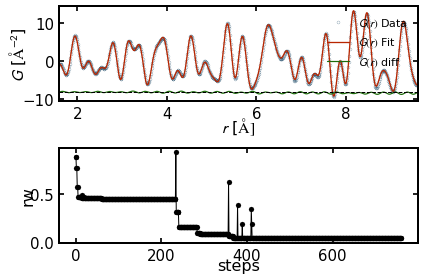

In [27]:
if __name__ == "__main__":
    main()